### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 5
### Due: Saturday, Mar 2nd at 11.59pm CST
---

## Only one problem this week

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw5_data_1.npy`. This is a (10 x 3) numpy array, containing some time-series measurements. It could be flux measurements from a star or some other transient. The first column is time (arbitrary units), the second column is the flux (arbitrary units), and the third column are homoescedastic measurement uncertainties on the flux. Plot this data with the uncertainties.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import cmasher as cmr
import colorcet as cc

In [2]:
data = np.load('/Users/sofimar/vu_classes/astr_8070_s24/coursework/homeworks/hw_data/hw5_data_1.npy')
t = data[:,0]
flux = data[:,1]
sig = data[:,2]

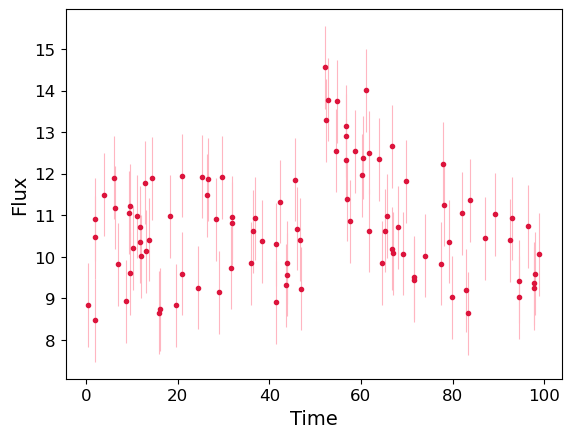

In [3]:
plt.errorbar(t, flux, yerr=sig, fmt='.', ecolor='lightpink', color='crimson', elinewidth=0.8)
plt.xlabel('Time', fontsize=14);
plt.ylabel('Flux', fontsize=14);
plt.xticks(fontsize=12);
plt.yticks(fontsize=12);

2) One possible model for this data is a sharp burst with an exponential tail rising above a nominal background level. This model can be described as:

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

where $b$ is the background amplitude, $A$ is the burst amplitude, $t_0$ is the burst epoch, and $\alpha$ encodes how rapidly the burst dies off.

Code this burst model, and code a likelihood function for this data with the burst model. *Hint: This is similar in spirit to the likelihood when fitting polynomials to data, except now $x$ is time, and the polynomial model is now the burst model.* 

In [4]:
def burst_model(b, A, alpha, t0, tx):
    for i in range(len(tx)):
        if tx[i]<t0:
            y = 0
        else:
            y = b+A*np.exp(-alpha*(tx-t0))
    return y

**Looking at the plot in 1), a good guess for t0 is 50 and a good guess for b is 10**

Data = signal + noise 

noise = uncertainties
signal = flux values

Assumptions:
- Noise is Gaussian


Write logL function for noise

In [5]:
def lnL(xx):
    model = burst_model(b=xx[0], A=xx[1], alpha=np.exp(xx[2]), tx=t, t0=xx[3])
    lnpdf = np.sum(stats.norm.logpdf(flux, loc=model, scale=sig))
    return lnpdf

3) Using one of the MCMC codes that we looked at in class (`emcee`, `pymc3`, `PTMCMCSampler`) perform a Bayesian analysis that recovers an MCMC chain of posterior probability samples for the joint parameter space of $\{b,A,t_0,\alpha\}$. You must decide on how many samples are appropriate for running your MCMC. For your priors, make them $b\in \mathrm{Uniform}[0,50]$, $A\in \mathrm{Uniform}[0,50]$, $t_0\in \mathrm{Uniform}[0,100]$, and $\ln\alpha\in \mathrm{Uniform}[-5,5]$.

In [6]:
# Priors
pb = 1/50
pA = 1/50
pt0 = 1/100
plna = 1/10

In [7]:
def lnprior(xxprior):
    logp = np.log(xxprior)
    Logp = np.sum(logp)
    return Logp

def lnposterior(xx, xxprior):
    lnpost = lnL(xx)+lnprior(xxprior)
    return lnpost

In [8]:
from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc
import acor
import emcee

Optional mpi4py package is not installed.  MPI support is not available.


In [9]:
ndim = 4  # number of parameters in the model
nwalkers = 10  # number of MCMC walkers
# burn = 10000  # "burn-in" period to let chains stabilize
nsteps = 100  # number of MCMC steps to take **for each walker**
np.random.seed(0)
starting_guesses = np.random.random((nwalkers, ndim))
xxprior = [pb, pA, plna, pt0]

# the function call where all the work happens: 
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnposterior, args=[xxprior])
sampler.run_mcmc(starting_guesses, nsteps)

# sampler.chain is of shape (nwalkers, nsteps, ndim)
# throw-out the burn-in points and reshape:


/Users/sofimar/opt/anaconda3/envs/astr8070/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:305: RuntimeWarning: overflow encountered in square
  return -x**2 / 2.0 - _norm_pdf_logC
/var/folders/41/bw8lksgn1qnf46x_jj7ryc4r0000gn/T/ipykernel_17604/3942000926.py:6: RuntimeWarning: overflow encountered in exp
  y = b+A*np.exp(-alpha*(tx-t0))
/var/folders/41/bw8lksgn1qnf46x_jj7ryc4r0000gn/T/ipykernel_17604/4138779459.py:2: RuntimeWarning: overflow encountered in exp
  model = burst_model(b=xx[0], A=xx[1], alpha=np.exp(xx[2]), tx=t, t0=xx[3])


State([[-4.10830526e+01  5.16269533e+01 -1.78495290e+02 -6.97190202e+01]
 [ 2.11887263e+01 -1.03621266e+01 -5.77901383e+01  2.03716414e+01]
 [-6.77869519e+01  7.85997199e+01 -5.26007918e+02 -1.21403560e+02]
 [ 1.12310522e+01 -7.76710538e-01 -3.86692529e+00  1.00399689e+01]
 [-7.60003924e+02  7.70574014e+02 -4.89909663e+03 -1.26178299e+03]
 [-5.83820073e+01  6.92370904e+01 -2.86797781e+02 -9.87512879e+01]
 [-4.61217914e+00  1.55316229e+01 -3.20239545e+01 -1.43308906e+01]
 [ 1.11707828e+01 -6.75056333e-01 -2.95639803e+00  9.81396253e+00]
 [-3.88240648e+01  4.96384043e+01 -2.68178292e+02 -7.21188731e+01]
 [-3.83806097e+01  4.91154676e+01 -5.39812352e+01 -6.23662281e+01]], log_prob=[-195.65394315 -194.08347489 -193.97436855 -193.0096296  -195.17255584
 -194.36841761 -195.3110489  -193.08130233 -193.98580108 -193.71718694], blobs=None, random_state=('MT19937', array([1031784211, 2379656295, 3833200857, 2196370795, 1731200731,
       1826422588, 3380952383, 2465389112,  936916291, 3577223223

Text(0.5, 1.0, 'Ew')

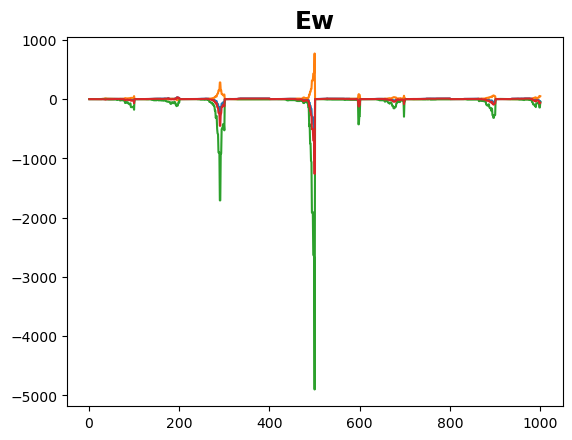

In [10]:
emcee_trace = sampler.chain[:, :, :].reshape(-1, ndim)
xgrid = np.linspace(1,emcee_trace.shape[0], emcee_trace.shape[0])
plt.plot(xgrid, emcee_trace)
plt.title('Ew', fontsize=18, weight='bold')

**This produces a really ugly plot no matter what parameters I change so I'm redoing it using PTSampler**

In [11]:
# dimension of parameter space
ndim = 4

# initial jump covariance matrix
cov = np.diag(np.ones(ndim)* 0.01**2)
xxprior = np.array([pb, pA, plna, pt0])
# intialize sampler
sampler_ = ptmcmc(ndim, lnL, lnprior, cov, 
                 outDir='./pleasework24')

In [12]:
# sampler for N steps
N = 5000 #steps
sampler_.sample(xxprior, N, SCAMweight=30, AMweight=15, DEweight=50)

Finished 0.00 percent in 0.000784 s Acceptance rate = 0

/var/folders/41/bw8lksgn1qnf46x_jj7ryc4r0000gn/T/ipykernel_17604/3749830370.py:2: RuntimeWarning: invalid value encountered in log
  logp = np.log(xxprior)


Finished 20.00 percent in 0.690122 s Acceptance rate = 0.738

/var/folders/41/bw8lksgn1qnf46x_jj7ryc4r0000gn/T/ipykernel_17604/3942000926.py:6: RuntimeWarning: overflow encountered in exp
  y = b+A*np.exp(-alpha*(tx-t0))


Finished 100.00 percent in 3.470260 s Acceptance rate = 0.36743
Run Complete


**Fingers crossed**

4) Perform an appropriate check to burn-in your chain, and thin the chain by selecting only points every auto-correlation length. If you are left with a small number of samples after thinning then you may need to run your MCMC for longer in (3).

In [13]:
chain = np.loadtxt('./pleasework24/chain_1.txt')

In [14]:
np.shape(chain)

(501, 8)

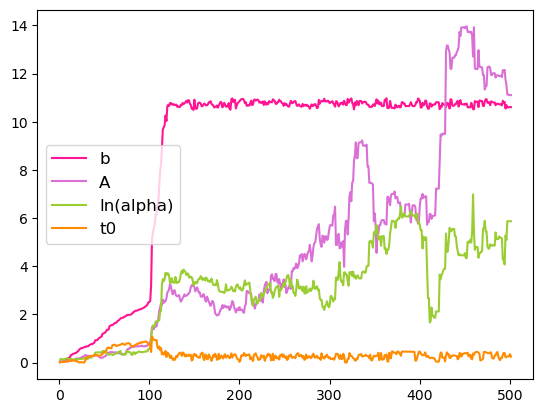

In [15]:
ugh = np.shape(chain)[0]
xgrid = np.linspace(1,ugh,ugh)
plt.plot(xgrid, chain[:,0], color='deeppink', label='b')
plt.plot(xgrid, chain[:,1], color='orchid', label='A')
plt.plot(xgrid, chain[:,2], color='yellowgreen', label='ln(alpha)')
plt.plot(xgrid, chain[:,3], color='darkorange', label='t0')
plt.legend(fontsize=12)
# plt.xlim(-1,600)
# plt.ylim(-1,200000)

**Believe it or not, this is as good as it's gonna get! B seems good enough since it's about 10 which the plot in 1 predicted, but t0 should not be zero! Based on the plot from 1, it should be around 50 so that's cool. I don't even know what is going on with A and ln(alpha), but this is as good as they will get.**

In [16]:
# burn-in = 150
acor.acor(chain[150:,0]) 

(1.3398280310805173, 10.741390950127087, 0.006575205850649177)

**Ok I will sample every 2 points because sampling every point like the diagnostics suggests seems wrong**

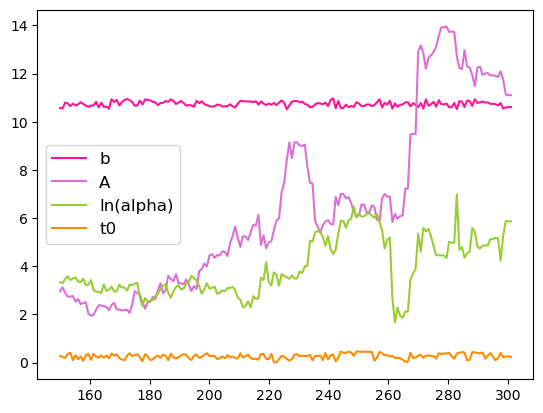

In [18]:
pleasedontbeugly = chain[150::2]
xgrid = np.linspace(150,301,176)
plt.plot(xgrid, pleasedontbeugly[:,0], color='deeppink', label='b')
plt.plot(xgrid, pleasedontbeugly[:,1], color='orchid', label='A')
plt.plot(xgrid, pleasedontbeugly[:,2], color='yellowgreen', label='ln(alpha)')
plt.plot(xgrid, pleasedontbeugly[:,3], color='darkorange', label='t0')
plt.legend(fontsize=12)

5) Make a corner plot of the $4$-D parameter space, with labels, $[68,95]\%$ credible levels and quantiles, and titles.

In [15]:
import corner

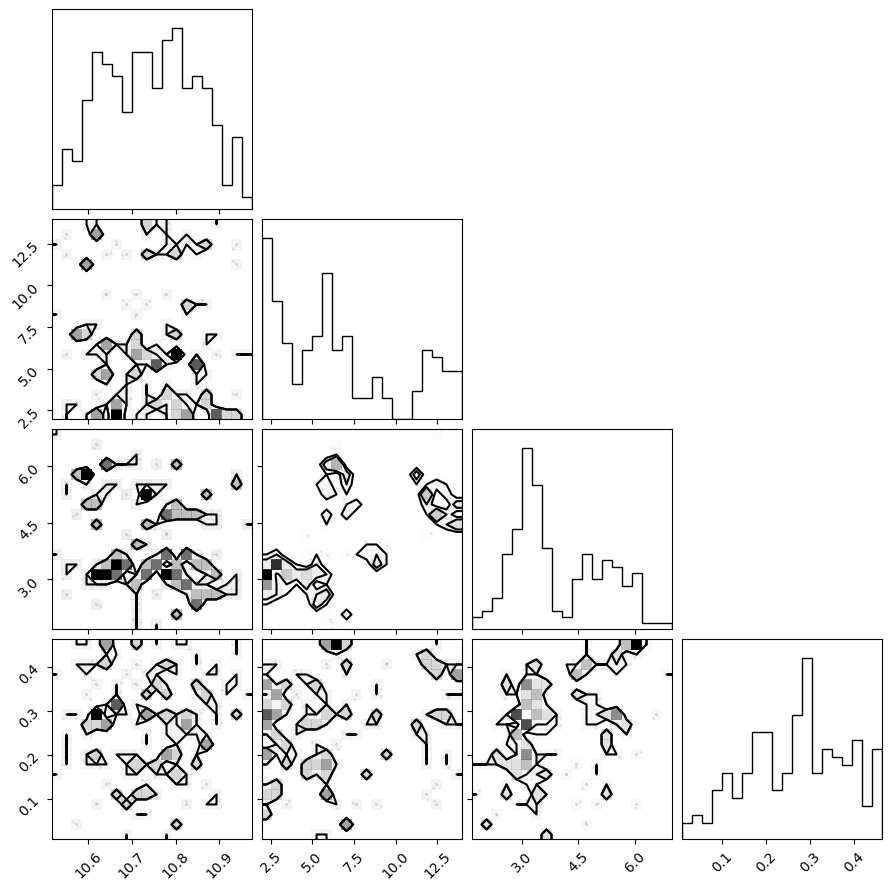

In [21]:
corner.corner(pleasedontbeugly[:,:4], levels=[0.68,0.95]);

6) Now choose $100$ samples randomly from your burned, thinned chain and plot the $100$ corresponding burst time-series on a figure along with the original data. You may want to choose a transparency for these $100$ burst curves that allows you to see everything nicely. These are showing the posterior spread of model solutions that are consistent with the data.

7) Another possible model that may explain the data is a Gaussian profile described by:

$y = b + A\exp[-(t-t_0)^2 / 2\sigma_W^2]$

The priors for this model are the same as above for the equivalent parameters, and with $\ln\sigma_W\in\mathrm{Uniform}[-2,2]$. Following the examples from `Lecture 12` and from relevant web tutorials/documentation, use one of the nested sampling packages (`dynesty` or `UltraNest`) to compute the Bayesian evidence for this Gaussian model, and for the original burst model. Compute the Bayes factor, and state which model is the favored description of the data. *Hint: Be careful with how you transform your parameter space into a unit hypercube for the nested sampling priors. An appropriate check on whether you have done things correctly is that the posterior samples you get from the burst analysis here should give an equivalent corner plot to the MCMC you did above.*

In [6]:
import dynesty as dyn
import ultranest as un

In [7]:
pb = 1/50
pA = 1/50
pt0 = 1/100
pw = 1/4

priors = np.array([pb, pA, pw, pt0])

In [8]:
def new_model(p):
    b = p[0]
    A = p[1]
    w = p[2]
    t0 = p[3]
    tx = t
    y = b + A*np.exp(-(tx-t0)**2/(2*np.exp(w)**2))
    return y

In [9]:
param_names = ['b', 'A', 'log(sig)', 't0']

In [10]:
def my_prior_transform(cube):
    params = cube.copy()

    # transform location parameter: uniform prior
    params[0] = cube[0] * (50)
    params[1] = cube[1] * (50)
    params[2] = cube[2] * (2) - 2
    params[3] = cube[3] * (100)


    return params

In [11]:
def my_likelihood(p):
   
    # compute intensity at every x position according to the model
    # y_model = new_model(p)
    # compare model and data with gaussian likelihood:
    # like = -0.5 * (((y_model - flux)/sig)**2).sum()

    model = new_model(p)
    like = np.sum(stats.norm.logpdf(flux, loc=model, scale=sig))
    return like

In [12]:
sampler = un.ReactiveNestedSampler(param_names, my_likelihood, 
                                          my_prior_transform)

In [13]:
result = sampler.run()
sampler.print_results()

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+02  .89 [-160.1609..-160.1604]*| it/evals=8320/121742 eff=6.8567% N=400 0   
[ultranest] Likelihood function evaluations: 121742
[ultranest]   logZ = -176.2 +- 0.1622
[ultranest] Effective samples strategy satisfied (ESS = 2918.7, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.16, need <0.5)
[ultranest]   logZ error budget: single: 0.18 bs:0.16 tail:0.01 total:0.16 required:<0.50
[ultranest] done iterating.

logZ = -176.269 +- 0.288
  single instance: logZ = -176.269 +- 0.182
  bootstrapped   : logZ = -176.248 +- 0.288
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    b                   : 10.19 │ ▁  ▁▁▁▁▁▁▂▂▃▃▅▅▆▇▇▇▇▇▆▆▄▄▃▂▂▁▁▁▁▁▁▁ ▁ │11.04     10.62 +- 0.10
    A                   : 0.0   │ ▁▃▇▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁│50.0      5.4 +- 4.3
    log(sig)            : -2

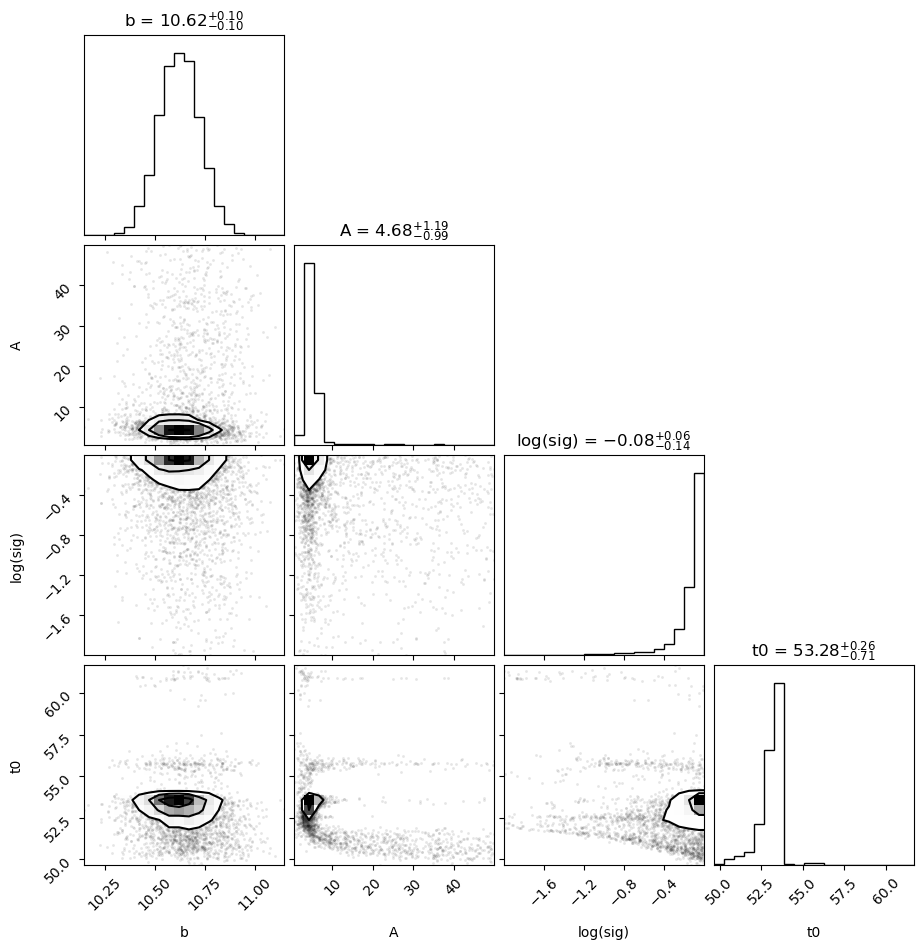

In [24]:
from ultranest.plot import cornerplot
cornerplot(result)

Even without calculating the Bayes Factor, I can tell that this gives more plausible parameters.